In [ ]:
%env CUDA_VISIBLE_DEVICES=1

In [18]:
TRAIN_2019_QA_PAIRS = "/mnt/workspace/imageclef/2019-Dataset/2019-QAPairsByCategory/C4_Abnormality_train.txt"
TRAIN_2019_IMAGES = "/mnt/workspace/imageclef/2019-Dataset/2019-Train-Images/"

DATASET_COMMON_FOLDER = "/mnt/workspace/imageclef/2020-2021-Datasets/VQA/"

TRAIN_2020_IMAGES = DATASET_COMMON_FOLDER + "VQAMed2020-VQAnswering-TrainingSet/" \
                                              "VQAnswering_2020_Train_images/"
TRAIN_2020_QA_PAIRS = DATASET_COMMON_FOLDER + "VQAMed2020-VQAnswering-TrainingSet/" \
                                              "VQAnswering_2020_Train_QA_pairs.txt"
VAL_2020_IMAGES = DATASET_COMMON_FOLDER + "VQAMed2020-VQAnswering-ValidationSet/" \
                                          "VQAnswering_2020_Val_images/"
VAL_2020_QA_PAIRS = DATASET_COMMON_FOLDER + "VQAMed2020-VQAnswering-ValidationSet/" \
                                            "VQAnswering_2020_Val_QA_Pairs.txt"
VAL_2021_IMAGES = DATASET_COMMON_FOLDER + "VQA-Med-2021-Tasks-1-2-NewValidationSets/" \
                                          "ImageCLEF-2021-VQA-Med-New-Validation-Images/"
VAL_2021_QA_PAIRS = DATASET_COMMON_FOLDER + "VQA-Med-2021-Tasks-1-2-NewValidationSets/" \
                                            "VQA-Med-2021-VQAnswering-Task1-New-ValidationSet.txt"
TEST_2021_IMAGES = DATASET_COMMON_FOLDER + "VQA-500-Images/"
TEST_2021_QUESTIONS = DATASET_COMMON_FOLDER + "Task1-VQA-2021-TestSet-Questions.txt"
TEST_2021_ANSWERS = DATASET_COMMON_FOLDER + "Task1-VQA-2021-TestSet-ReferenceAnswers.txt"

In [133]:
import pandas as pd
import re
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from PIL import Image
import nltk
from nltk.corpus import stopwords
import pickle
import unicodedata
import random

In [4]:
torch.cuda.set_device(2)

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [74]:
token_regex = re.compile(r'[a-z0-9][a-z0-9\-\']*|[\-,\.\(\)]')

In [177]:
token_regex_no_punct = re.compile(r'[a-z][a-z0-9\-\']*')

In [210]:
def load_id2question_id2answer_id2imgfolder():
    train_2019_qa_pairs = pd.read_csv(TRAIN_2019_QA_PAIRS, sep="|", header=None)
    train_2020_qa_pairs = pd.read_csv(TRAIN_2020_QA_PAIRS, sep="|", header=None)
    val_2020_qa_pairs = pd.read_csv(VAL_2020_QA_PAIRS, sep="|", header=None)
    val_2021_qa_pairs = pd.read_csv(VAL_2021_QA_PAIRS, sep="|", header=None)
    test_2021_questions = pd.read_csv(TEST_2021_QUESTIONS, sep="|", header=None)
    test_2021_answers = pd.read_csv(TEST_2021_ANSWERS, sep="|", header=None)
    id2question = dict()
    id2answer = dict()
    id2imgfolder = dict()
    for df, folder in zip((train_2019_qa_pairs, train_2020_qa_pairs, val_2020_qa_pairs, val_2021_qa_pairs),
                          (TRAIN_2019_IMAGES, TRAIN_2020_IMAGES, VAL_2020_IMAGES, VAL_2021_IMAGES)):
        for i in range(len(df)):
            id2question[df[0][i]] = df[1][i]
            id2answer[df[0][i]] = df[2][i]
            id2imgfolder[df[0][i]] = folder
            
    df = test_2021_questions
    for _id, q in zip(df[0], df[1]):
        id2question[_id] = q
        id2imgfolder[_id] = TEST_2021_IMAGES
    df = test_2021_answers
    for _id, a1, a2, a3 in zip(df[0], df[1], df[2], df[3]):
        a = ''
        for x in (a1, a2, a3):            
            if type(x) == str:
                if len(a) > 0:
                    a += ', '
                a += x
        id2answer[_id] = a
    for _id in id2question.keys():
        id2question[_id] = ' '.join(token_regex.findall(unicodedata.normalize('NFKD', id2question[_id])))
    for _id in id2answer.keys():
        id2answer[_id] = ' '.join(token_regex.findall(unicodedata.normalize('NFKD', id2answer[_id])))
    return id2question, id2answer, id2imgfolder

In [211]:
id2question, id2answer, id2imgfolder = load_id2question_id2answer_id2imgfolder()

In [212]:
len(id2question), len(id2answer), len(id2imgfolder)

(8692, 8692, 8692)

In [103]:
image_type_regexs = [
    re.compile(r'\bgastrointestinal\b'),
    re.compile(r'\bx-ray\b'),
    re.compile(r'\bultrasound\b'),
    re.compile(r'\bmri\b'),
    re.compile(r'\bct scan\b'),
    re.compile(r'\bpet scan\b'),
    re.compile(r'\bmammograph\b'),
    re.compile(r'\bangiogram\b'),
]

imagetype2name = [
    'unknown',
    'gastrointestinal',
    'x-ray',
    'ultrasound',
    'mri',
    'ct scan',
    'pet scan',
    'mammograph',
    'angiogram',
]

def detect_image_type(q):
    for i, r in enumerate(image_type_regexs):
        if r.search(q):
            return i+1
    return 0

In [93]:
unclassified = []
for q in id2question.values():
    if not detect_image_type(q) and 'image' not in q:
        unclassified.append(q)

In [125]:
class ImageDataset(Dataset):
    
    def __init__(self, ids, transform):
        self.image_paths = [id2imgfolder[_id] + _id + '.jpg' for _id in ids]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):    
        return dict(
            idx = i,
            img=self.transform(Image.open(self.image_paths[i]).convert('RGB')),
        )

In [126]:
def compute_features(cnn, ids, transform, batchsize):
    cnn.eval()
    dataloader = DataLoader(ImageDataset(ids, transform), batchsize, num_workers=8)
    with torch.set_grad_enabled(False):
        feat = None        
        for batch in tqdm(dataloader):
            idxs = batch['idx']
            imgs = batch['img']
            imgs.to(DEVICE)
            batch_feat = cnn(imgs)
            if feat is None:
                feat = np.empty((len(ids), batch_feat.size(1)))
            for i, idx in enumerate(idxs):
                feat[idx] = batch_feat[i]
    return feat

In [123]:
def get_closest_image(i, unclassified_feat, classified_feat):
    best_score = -9999
    best_j = None
    norm_i = np.linalg.norm(unclassified_feat[i])
    for j in range(classified_feat.shape[0]):
        norm_j = np.linalg.norm(classified_feat[j])
        score = np.dot(unclassified_feat[i], classified_feat[j]) / (norm_i * norm_j)
        if score > best_score:
            best_score = score
            best_j = j
    return best_j

In [129]:
def get_id2imgtype():
    global classified_feat
    global unclassified_feat
    
    id2imgtype = dict()
    classified_ids = []
    unclassified_ids = []
    
    for _id, q in id2question.items():
        id2imgtype[_id] = detect_image_type(q)
        if id2imgtype[_id]: classified_ids.append(_id)
        else: unclassified_ids.append(_id)
    
    densenet = models.densenet121(pretrained=True)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    classified_feat = compute_features(densenet, classified_ids, transform, 100)
    unclassified_feat = compute_features(densenet, unclassified_ids, transform, 100)
    
    for i, _id in tqdm(enumerate(unclassified_ids)):
        j = get_closest_image(i, unclassified_feat, classified_feat)
        id2imgtype[_id] = id2imgtype[classified_ids[j]]
    
    return id2imgtype

In [130]:
id2imgtype = get_id2imgtype()

100%|██████████| 44/44 [05:40<00:00,  7.74s/it]
4325it [01:46, 40.71it/s]


In [132]:
ids_list = list(id2imgtype.keys())

In [137]:
def inspect_image_type(_id = None):
    if _id is None: _id = random.choice(ids_list)
    print(imagetype2name[id2imgtype[_id]])
    return Image.open(id2imgfolder[_id] + _id + '.jpg').reduce(3)

x-ray


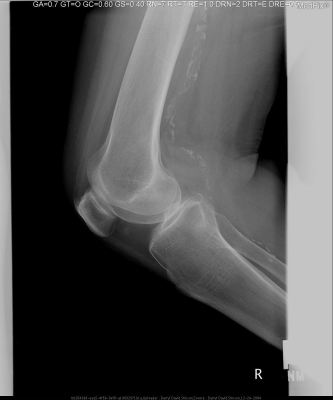

In [202]:
inspect_image_type()

In [178]:
def get_id2labels_labels(min_freq = 10):
    stopwords_set = set(stopwords.words('english'))    
    id2labels = dict()
    
    for _id, a in id2answer.items():            
        if a == 'yes' or a == 'no':
            id2labels[_id] = []
        else:
            id2labels[_id] = list(set(x for x in token_regex_no_punct.findall(a) if x not in stopwords_set))
    
    label_freq = dict()
    for words in id2labels.values():
        for w in words:
            label_freq[w] = label_freq.get(w, 0) + 1
            
    labels = [w for w, f in label_freq.items() if f >= min_freq]
    labels_set = set(labels)
    labels.sort()
    label2index = {w:i for i,w in enumerate(labels)}
    
    for _id in id2labels.keys():
        filtered = [w for w in id2labels[_id] if w in labels_set]
        if len(filtered) == 0:
            tmp = [0 for _ in range(len(labels))]
        else:
            tmp = [1 for _ in range(len(labels))]
            for w in filtered:
                tmp[label2index[w]] = 2
        id2labels[_id] = tmp
    return id2labels, labels

In [181]:
id2labels, labels = get_id2labels_labels(min_freq=10)

In [184]:
assert len(id2labels) == len(ids_list)
_count = 0
for _id in id2labels.keys():
    assert all(labels[i] in id2answer[_id] for i,v in enumerate(id2labels[_id]) if v == 2)
    _count += sum(1 for v in id2labels[_id] if v == 2) > 0
print(len(labels))
print(len(id2labels))
print(_count)

618
8692
8166


In [209]:
with open('id2imagefolder.pickle', 'wb') as f:
    pickle.dump(id2imgfolder, f, protocol=pickle.HIGHEST_PROTOCOL)

In [203]:
with open('id2imagetype.pickle', 'wb') as f:
    pickle.dump(id2imgtype, f, protocol=pickle.HIGHEST_PROTOCOL)

In [204]:
with open('id2labels.pickle', 'wb') as f:
    pickle.dump(id2labels, f, protocol=pickle.HIGHEST_PROTOCOL)

In [214]:
with open('id2answer.pickle', 'wb') as f:
    pickle.dump(id2answer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [206]:
with open('id2question.pickle', 'wb') as f:
    pickle.dump(id2question, f, protocol=pickle.HIGHEST_PROTOCOL)

In [207]:
with open('labels.pickle', 'wb') as f:
    pickle.dump(labels, f, protocol=pickle.HIGHEST_PROTOCOL)

In [208]:
with open('imagetype2name.pickle', 'wb') as f:
    pickle.dump(imagetype2name, f, protocol=pickle.HIGHEST_PROTOCOL)